In [1]:
import pandas as pd
import numpy as np
import numpy.polynomial.polynomial as P
from scipy import stats

import itertools as it
import textwrap

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn import decomposition as decomp
from sklearn import preprocessing as prep
from sklearn import manifold as mfold
from sklearn import model_selection as mselection
from sklearn import feature_selection as fselection
from sklearn import metrics as mets
from sklearn import linear_model as lmodel

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

In [2]:
iniN = 3
endN = 52

src = '../hpcc/traditional/'
dst = '../hpcc/results/trad/'

In [3]:
filename = src + 'traditional_phenotype_summary.csv'
df = pd.read_csv(filename)
X = df.iloc[:, iniN:].values

vif = np.zeros(X.shape[1])
for i in range(len(vif)):
    vif[i] = VIF(X,i)
    
arg = np.argsort(vif)
for i in range(10):
    print('{:02d}'.format(i+1), np.round(vif[arg[i]], 1), '\t', df.columns[arg[i] + iniN])

01 3.2 	 meat_arc_height
02 6.6 	 meat_cavity_height
03 9.1 	 meat_ratio_feret
04 13.6 	 shell_prot_ratio
05 16.1 	 meat_width
06 19.2 	 meat_length
07 20.3 	 shell_thickness
08 21.4 	 meat_height
09 23.3 	 shell_prot_vol
10 37.8 	 meat_ratio_cavity_vol


In [4]:
perbasis = 'accession'
filename = src + 'qual_quant_' + perbasis + '_summary.csv'
df = pd.read_csv(filename, dtype={1:str})

df = df.drop(index = df[df['PercentKernel'] == -1].index)
df['TipShrivel'] /= 100
df['MinorShrivel'] /= 100
df['MajorShrivel'] /= 100
df['PercentKernel'] /= 100

filename = src + 'col_labels.csv'
labels = pd.read_csv(filename, dtype=str, keep_default_na = False)
print(labels.shape)

cattraitnames = df.columns[endN:].values[[12,4,1,3,7,6,11,0,2]]
earliest = df[df['EaseOfRemoval'] == 7.5].index.values[0]
colnames = df.columns

for i in range(len(colnames)):
    if 'm' in labels.col_units[i]:
        df[colnames[i]] = np.log(df[colnames[i]])

data = df.drop(index=earliest)

print(df.shape, data.shape)
df.head()

(67, 2)
(149, 67) (148, 67)


,UCACCSD,nut_count,plot_count,nut_length,nut_height,nut_width,nut_vol,nut_va3d,nut_ratio_feret,nut_area,...,ShellThickness,PackingTissue,KernelFill,TipShrivel,MinorShrivel,MajorShrivel,Plumpness,EaseOfRemoval,PercentKernel,Blank
0,03-001-3395,6,4,3.722851,3.542478,3.546267,10.049243,5.061907,1.205837,8.815960,...,1.075000,5.000000,4.750000,0.000000,0.000000,0.0,4.750000,4.500000,0.623294,0.000000
1,04-004-626,9,1,3.729445,3.590846,3.518564,10.104634,4.624070,1.234757,8.822320,...,1.100000,5.000000,6.000000,0.000000,0.000000,0.0,4.000000,5.000000,0.583988,0.000000
2,06-004-4,16,7,3.612844,3.555183,3.480330,9.937941,4.320171,1.151675,8.687401,...,1.114286,5.000000,5.000000,0.000000,0.031746,0.0,3.857143,4.857143,0.589313,5.714286
3,06-005-27,15,4,3.701885,3.504070,3.436651,9.901554,4.605803,1.304487,8.685413,...,1.475000,5.750000,5.250000,0.000000,0.000000,0.0,3.500000,5.750000,0.482632,2.500000
4,06-030-18,5,3,3.635503,3.496012,3.452446,9.831883,4.443319,1.201473,8.627431,...,1.233333,5.666667,5.666667,0.033333,0.000000,0.0,5.000000,5.666667,0.461030,0.000000


# Choose target variable

In [6]:
data.columns[endN:]

Index(['ShellIntegrity', 'ShellTexture', 'ShellColor', 'SEAL', 'ShellStrength',
       'ShellThickness', 'PackingTissue', 'KernelFill', 'TipShrivel',
       'MinorShrivel', 'MajorShrivel', 'Plumpness', 'EaseOfRemoval',
       'PercentKernel', 'Blank'],
      dtype='object')

In [19]:
yvalue = 'PercentKernel'

X1 = df.iloc[:,iniN:endN].values.copy()
y1 = df[yvalue].values.copy()

Xscaler1 = prep.StandardScaler().fit(X1)
#yscaler1 = prep.StandardScaler().fit(y1.reshape(-1,1))

X1 = Xscaler1.transform(X1)
#y1 = yscaler1.transform(y1.reshape(-1,1))

################

X = data.iloc[:,iniN:endN].values.copy()
y = data[yvalue].values.copy()

Xscaler = prep.StandardScaler().fit(X)
#yscaler = prep.StandardScaler()

X = Xscaler.transform(X)
#y = yscaler.fit(y.reshape(-1,1)).transform(y.reshape(-1,1))

# Remove Earliest

In [20]:
alphas = np.linspace(-5,1,50)

alpha = 10
ridge = lmodel.Ridge(alpha=alpha).fit(X, y)
y_pred = ridge.predict(X)
r2 = mets.r2_score(y, y_pred)


ridge1 = lmodel.Ridge(alpha=alpha).fit(X1, y1)
y_preh = ridge1.predict(X1)
r21 = mets.r2_score(y1, y_preh)

print('Train\t',r2,'\nTest\t',r21)

Train	 0.8731161124418002 
Test	 0.781170712999178


../hpcc/results/trad/kernel_weight_ratio_ridge_regression


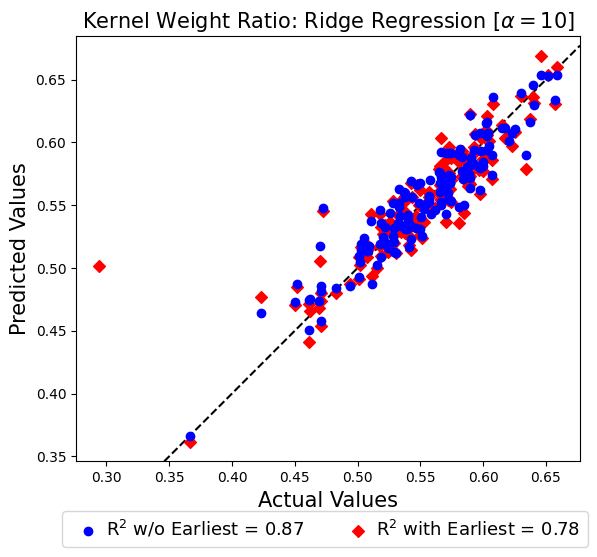

In [24]:
yvalue = 'Kernel Weight Ratio'
fs = 15
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.scatter(y, y_pred, 
           c='b', marker='o', zorder=10,
           label = 'R$^2$ w/o Earliest = {:.2f}'.format(r2))

ax.scatter(y1, y_preh,
           c='r', marker='D', zorder=3,
           label = 'R$^2$ with Earliest = {:.2f}'.format(r21))

ax.set_aspect('equal');
ax.axline((0.5,0.5), slope=1, c='k', ls='--', zorder=1)
ax.set_xlabel('Actual Values', fontsize=fs);
ax.set_ylabel('Predicted Values', fontsize=fs)
#ax.set_title(yvalue + ': OLS Regression', fontsize=fs);
ax.set_title(yvalue + ': Ridge Regression [$\\alpha=${}]'.format(alpha), fontsize=fs);

fig.legend(loc='lower center', bbox_to_anchor=(0.55,0.0), fontsize=fs-2, handletextpad=0., ncols=2)
fig.tight_layout()

filename = dst + yvalue.lower().replace(' ','_') + '_ridge_regression'
#plt.savefig(filename + '.jpg', dpi=150, bbox_inches='tight', pil_kwargs = {'optimize':True}, format='jpg')
plt.savefig(filename + '.svg', format='svg', bbox_inches='tight')
plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
print(filename)

# Find best regularization parameter for Lasso regression

In [15]:
rng = np.random.default_rng()

arr = np.arange(len(data))
choice = rng.choice(arr, int(np.ceil(len(arr)*0.75)), replace=False)
nonchoice = np.array(list(set(arr) - set(choice)))

X_train, y_train = X[choice].copy(), y[choice].copy()
X_test, y_test = X[nonchoice].copy(), y[nonchoice].copy()

#ridge = lmodel.Ridge(alpha=alpha).fit(X_train, y_train)
ridge = lmodel.Lasso(alpha=0.005).fit(X_train, y_train)
r2_train = ridge.score(X_train, y_train)

y_pred = ridge.predict(X_test)
r2_test = mets.r2_score(y_test, y_pred)

print('Train:\t',r2_train,'\nTest:\t',r2_test)

Train:	 0.5748586780707412 
Test:	 0.09480689410920917


In [16]:
N = 1000
alphas = np.linspace(0.005, 0.1, 20)
describe = np.zeros((len(alphas), 8, 2))
arr = np.arange(len(data))
testN = int(np.ceil(len(arr)*0.7))

for j in range(len(alphas)):
    alpha = alphas[j]
    R2 = np.zeros((N,2))

    for i in range(N):    
        rng = np.random.default_rng(i)
        choice = rng.choice(arr, testN, replace=False)
        nonchoice = np.setxor1d(arr, choice)

        X_train, y_train = X[choice].copy(), y[choice].copy()
        X_test, y_test = X[nonchoice].copy(), y[nonchoice].copy()

        #ridge = lmodel.Ridge(alpha=alpha).fit(X_train, y_train)
        ridge = lmodel.Lasso(alpha=alpha).fit(X_train, y_train)
        r2_train = ridge.score(X_train, y_train)

        y_pred = ridge.predict(X_test)
        r2_test = mets.r2_score(y_test, y_pred)
        R2[i] = [r2_train, r2_test]
    
    describe[j] = pd.DataFrame(R2, columns=['Train', 'Test']).describe().values
    
print('Train:\t',r2_train,'\nTest:\t',r2_test)

Train:	 0.4131584439212225 
Test:	 0.1630635301327753


../hpcc/results/trad/easeofremoval_lasso_7030


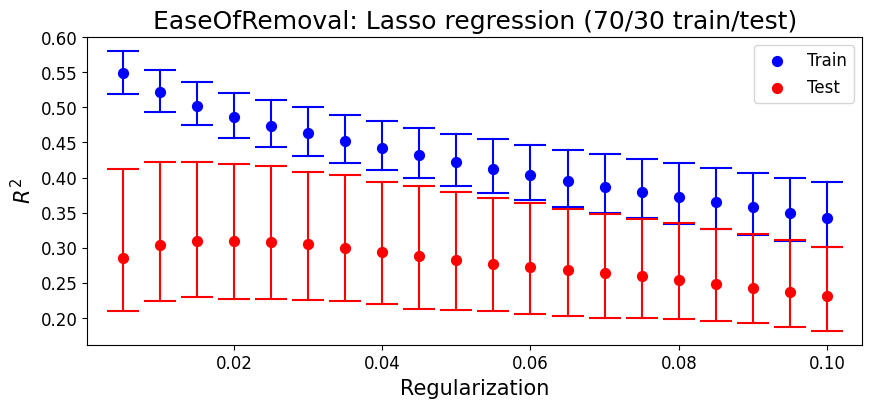

In [17]:
reg = str(type(ridge)).split('.')[-1][:-2]
fs = 15
fig, ax = plt.subplots(1,1,figsize=(10,4))
ax = np.atleast_1d(ax).ravel(); i=0
c = ['blue','red']
l = ['Train','Test']
for j in range(2):
    ax[i].scatter(alphas, describe[:,1,j], color=c[j], label=l[j], s=50)
    ax[i].scatter(alphas, describe[:,4,j], color=c[j], marker='_', s=500)
    ax[i].scatter(alphas, describe[:,6,j], color=c[j], marker='_', s=500)
    for k in range(len(alphas)):
        ax[i].plot([alphas[k], alphas[k]], describe[k,[4,6],j], color=c[j])

ax[i].set_ylabel('$R^2$', fontsize=fs, rotation=90)
ax[i].set_xlabel('Regularization', fontsize=fs)
ax[i].tick_params(labelsize=fs-3)
ax[i].set_title(yvalue + ': ' + reg +' regression (70/30 train/test)', fontsize=fs+3)
ax[i].legend(fontsize=fs-3);

filename = dst + yvalue.lower() + '_' + reg.lower()+ '_7030'
plt.savefig(filename + '.jpg', dpi=150, bbox_inches='tight', pil_kwargs = {'optimize':True}, format='jpg')
plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
print(filename)

In [19]:
print('optimal alpha: ', alphas[np.argmax(describe[:,1,1])])
print(describe[np.argmax(describe[:,1,1])])

optimal alpha:  0.02
[[ 1.00000000e+03  1.00000000e+03]
 [ 4.86832710e-01  3.09144959e-01]
 [ 5.01366211e-02  1.55793604e-01]
 [ 2.90410921e-01 -5.13047836e-01]
 [ 4.56526816e-01  2.27672604e-01]
 [ 4.94197506e-01  3.36043351e-01]
 [ 5.20509919e-01  4.19659682e-01]
 [ 6.25919114e-01  6.27242629e-01]]


# Fix $\alpha$ and explore the most relevant coefficients

In [20]:
N = 1000
alpha = alphas[np.argmax(describe[:,1,1])]
R2 = np.zeros((N,2))
coefs = np.zeros((N,X.shape[1]))

arr = np.arange(len(data))
testN = int(np.ceil(len(arr)*0.7))
    
for i in range(N):    
    rng = np.random.default_rng(i)
    choice = rng.choice(arr, testN, replace=False)
    nonchoice = np.setxor1d(arr, choice)

    X_train, y_train = X[choice].copy(), y[choice].copy()
    X_test, y_test = X[nonchoice].copy(), y[nonchoice].copy()

    ridge = lmodel.Lasso(alpha=alpha).fit(X_train, y_train)
    r2_train = ridge.score(X_train, y_train)

    y_pred = ridge.predict(X_test)
    r2_test = mets.r2_score(y_test, y_pred)
    R2[i] = [r2_train, r2_test]
    coefs[i] = ridge.coef_

../hpcc/results/trad/easeofremoval_Lasso_R2_train_vs_test


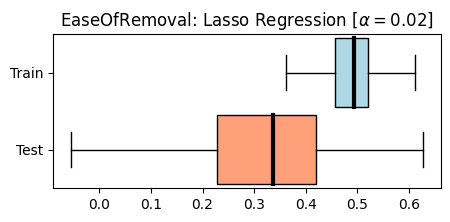

In [22]:
fs = 12
reg = str(type(ridge)).split('.')[-1][:-2]

fig, ax = plt.subplots(1,1,figsize=(5,2))
colors = ['lightsalmon','lightblue']
bplot = ax.boxplot(np.flip(R2), notch=False, sym='', vert=False, widths=0.9, patch_artist=True,
                   medianprops={'lw':3, 'color':'k'}, labels=['Test', 'Train'])

for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        
ax.set_title(yvalue + ': ' + reg + ' Regression [$\\alpha=${}]'.format(ridge.alpha), fontsize=fs);

filename = dst + yvalue.lower() + '_' + reg + '_R2_train_vs_test'
plt.savefig(filename + '.jpg', dpi=150, bbox_inches='tight', pil_kwargs = {'optimize':True}, format='jpg')
plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
print(filename)

../hpcc/results/trad/easeofremoval_lasso_coefs


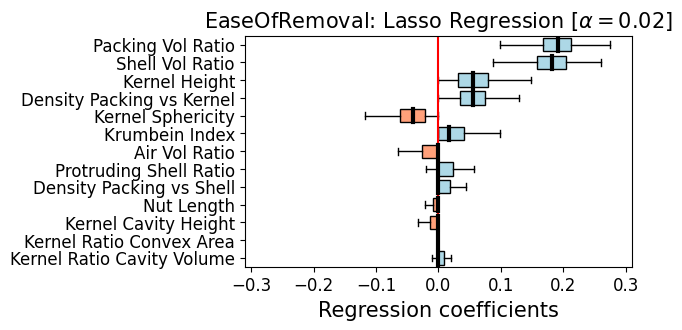

In [23]:
fs = 15
fabs = np.abs(np.mean(coefs, axis=0))
r_mask = fabs > 0.005
aabs = np.argsort(fabs[r_mask])
mabs = np.mean(coefs[:,r_mask][:,aabs], axis=0)

fig, ax = plt.subplots(1,1,figsize=(5,3))

colors = ['lightsalmon','lightblue']

bplot = ax.boxplot(coefs[:,r_mask][:,aabs], notch=False, sym='', vert=False, widths=0.75, patch_artist=True,
                   medianprops={'lw':3, 'color':'k'},
                   labels = labels.col_labels.iloc[iniN:endN].iloc[r_mask].iloc[aabs])
ax.scatter([-np.max(coefs), np.max(coefs)], [5,5], c='w', alpha=0)

for i,patch in enumerate(bplot['boxes']):
    if mabs[i] > 0:
        patch.set_facecolor(colors[1])
    else:
        patch.set_facecolor(colors[0])

ax.axvline(0, c='r')
ax.set_title(yvalue + ': ' + reg + ' Regression [$\\alpha=${}]'.format(ridge.alpha), fontsize=fs)
ax.set_xlabel('Regression coefficients', fontsize=fs)
ax.tick_params(labelsize=fs-3)

filename = dst + yvalue.lower() + '_' + reg.lower() + '_coefs'
plt.savefig(filename + '.jpg', dpi=150, bbox_inches='tight', pil_kwargs = {'optimize':True}, format='jpg')
plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
print(filename)

In [95]:
labels.col_labels.iloc[r_vals].iloc[aabs]

27        Protruding Shell Ratio
45      Density Packing vs Shell
43    Kernel Ratio Cavity Volume
40          Kernel Cavity Height
46     Density Packing vs Kernel
41             Kernel Sphericity
23               Shell Vol Ratio
24             Packing Vol Ratio
Name: col_labels, dtype: object

# Limit to select features. Do OLS

In [52]:
rng = np.random.default_rng()

choice = rng.choice(arr, testN, replace=False)
nonchoice = np.setxor1d(arr, choice)

X_train, y_train = X[choice][:,r_mask].copy(), y[choice].copy()
X_test, y_test = X[nonchoice][:,r_mask].copy(), y[nonchoice].copy()

#ridge = lmodel.Ridge(alpha=alpha).fit(X_train, y_train)
ridge = lmodel.LinearRegression().fit(X_train, y_train)
r2_train = ridge.score(X_train, y_train)

y_pred = ridge.predict(X_test)
r2_test = mets.r2_score(y_test, y_pred)

print('Train:\t',r2_train,'\nTest:\t',r2_test,'\nCoef:\t',ridge.coef_)

Train:	 0.5031537328993687 
Test:	 0.3988094015815824 
Coef:	 [-0.27982237 -0.12271524 -0.05987198  0.26792195  0.12217706  0.06943362
  0.24686206  0.04041764  0.04574441 -0.11042806 -0.03137655  0.09025406
 -0.02732418]


# Feature selection

In [60]:
#foo = iniN + np.nonzero(mi > thr)[0]
r_vals = iniN + np.nonzero(r_mask)[0]
X = data.iloc[:,r_vals].values.copy()
X = prep.StandardScaler().fit_transform(X)

N = 3
R22 = np.zeros(X.shape[1])
idx = [None for i in range(len(R22))]

for i in range(X.shape[1]):
    N = i+1
    for comb in it.combinations(range(X.shape[1]), N):
        arr = np.array(comb)
        X1 = X[:,arr].copy()

        ridge = lmodel.LinearRegression().fit(X1, y)
        y_pred = ridge.predict(X1)
        r2 = mets.r2_score(y, y_pred)

        if r2 > R22[i]:
            R22[i] = r2
            idx[i] = comb

In [64]:
for i in range(X.shape[1]):
    print(i+1, ': R2 ', R22[i])
    for j in idx[i]:
        print(labels.col_labels[r_vals[j]])
    print('--')

1 : R2  0.25776926767326447
Packing Vol Ratio
--
2 : R2  0.39942744398397934
Shell Vol Ratio
Packing Vol Ratio
--
3 : R2  0.42846422185605026
Shell Vol Ratio
Packing Vol Ratio
Kernel Height
--
4 : R2  0.45830009115221504
Shell Vol Ratio
Packing Vol Ratio
Kernel Height
Density Packing vs Shell
--
5 : R2  0.4744723900805269
Nut Length
Shell Vol Ratio
Packing Vol Ratio
Kernel Height
Density Packing vs Shell
--
6 : R2  0.49467425320309144
Nut Length
Shell Vol Ratio
Packing Vol Ratio
Kernel Height
Kernel Sphericity
Density Packing vs Shell
--
7 : R2  0.5018850867258495
Nut Length
Krumbein Index
Shell Vol Ratio
Packing Vol Ratio
Kernel Height
Kernel Sphericity
Density Packing vs Shell
--
8 : R2  0.5051449789821907
Nut Length
Krumbein Index
Air Vol Ratio
Shell Vol Ratio
Packing Vol Ratio
Kernel Height
Kernel Sphericity
Density Packing vs Shell
--
9 : R2  0.5080133634107856
Nut Length
Krumbein Index
Air Vol Ratio
Shell Vol Ratio
Packing Vol Ratio
Kernel Height
Kernel Ratio Convex Area
Kernel R

In [69]:
R22

array([0.25776927, 0.39942744, 0.42846422, 0.45830009, 0.47447239,
       0.49467425, 0.50188509, 0.50514498, 0.50765522, 0.5088823 ,
       0.50971063, 0.50991655, 0.51003644])

In [65]:
R22 = np.zeros(X.shape[1])
idx = np.zeros(len(R22), dtype=int)-1

for i in range(len(R22)):
    ridge = lmodel.LinearRegression().fit(X[:,i].reshape(-1,1), y.reshape(-1,1))
    y_pred = ridge.predict(X[:,i].reshape(-1,1)).squeeze()
    r2 = mets.r2_score(y, y_pred)
    if r2 > R22[0]:
        R22[0] = r2
        idx[0] = i
        
for i in range(1,len(R22)):
    for j in range(len(R22)):
        if j not in idx:
            arr = np.hstack((idx[:i], [j]))
            X1 = X[:,arr].copy()
    
            ridge = lmodel.LinearRegression().fit(X1, y)
            y_pred = ridge.predict(X1)
    
            r2 = mets.r2_score(y, y_pred)
            if r2 > R22[i]:
                R22[i] = r2
                idx[i] = j
                
                
ridge = lmodel.LinearRegression().fit(X,y)
R22[-1] = ridge.score(X,y)
idx[-1] = list(set(range(len(R22))) - set(idx[:-1]))[0]

../hpcc/results/trad/easeofremoval_linearregression_R2_progression


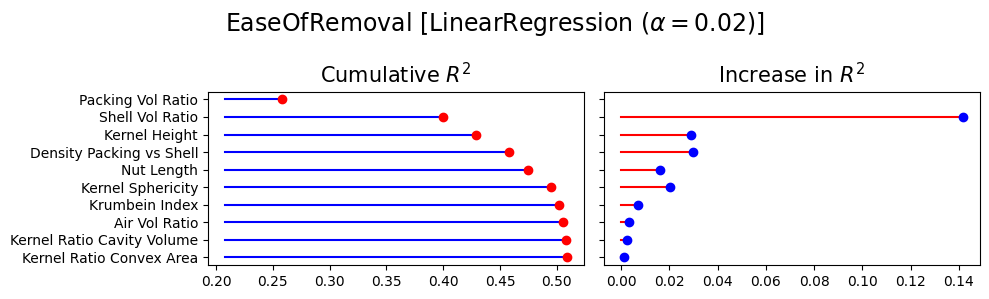

In [68]:
reg = str(type(ridge)).split('.')[-1][:-2]
fig, ax = plt.subplots(1,2,figsize=(10,3), sharey=True)

diff = np.ediff1d(R22)
mask = np.zeros(len(R22), dtype=bool)
mask[0] = True
mask[1:np.sum(diff > 1e-3)+1] = True

yaxis = np.arange(np.sum(mask), 0, -1)

for i in range(np.sum(mask)):
    ax[0].plot([R22[0]-0.05, R22[i]], [np.sum(mask)-i, np.sum(mask)-i], c='b', zorder=1)
ax[0].scatter(R22[mask], yaxis, color='r', zorder=2)

ax[0].set_title("Cumulative $R^2$", fontsize=fs)
ax[0].set_yticks(yaxis, labels.col_labels.iloc[r_vals[idx]].iloc[:np.sum(mask)]);

ax[1].set_title('Increase in $R^2$', fontsize=fs)
for i in range(1,np.sum(mask)):
    ax[1].plot([0, diff[i-1]], [np.sum(mask)-i, np.sum(mask)-i], c='r', zorder=1)
ax[1].scatter(diff[mask[1:]], yaxis[1:], color='b', zorder=2)

fig.suptitle(yvalue + " [" + reg + " ($\\alpha=${})]".format(alpha), fontsize=fs+2)
fig.tight_layout();

filename = dst + yvalue.lower() + '_' + reg.lower() + '_R2_progression'
#plt.savefig(filename + '.jpg', dpi=150, bbox_inches='tight', pil_kwargs = {'optimize':True}, format='jpg')
#plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
print(filename)

# Variance Inflation Factor

In [77]:
vif = np.zeros(X.shape[1])

for i in range(len(vif)):
    vif[i] = VIF(X,i)
    
arg = np.argsort(vif)
for i in range(len(vif)):
    print('{:02d}'.format(i+1), np.round(vif[arg[i]], 1), '\t', labels.col_labels.iloc[r_vals[arg][i]])

01 1.4 	 Protruding Shell Ratio
02 1.5 	 Kernel Ratio Cavity Volume
03 3.3 	 Packing Vol Ratio
04 3.7 	 Kernel Cavity Height
05 7.2 	 Density Packing vs Kernel
06 7.6 	 Density Packing vs Shell
07 8.2 	 Kernel Sphericity
08 10.1 	 Shell Vol Ratio
09 12.6 	 Kernel Ratio Convex Area
10 12.7 	 Kernel Height
11 15.5 	 Krumbein Index
12 23.9 	 Air Vol Ratio
13 25.4 	 Nut Length


In [84]:
r_vals = iniN + np.nonzero(r_mask)[0]
r_vals = r_vals[np.nonzero(vif < vif_thr)[0]]

X = data.iloc[:,r_vals].values.copy()
X = prep.StandardScaler().fit_transform(X)

N = 3
R22 = np.zeros(X.shape[1])
idx = [None for i in range(len(R22))]

for i in range(X.shape[1]):
    N = i+1
    for comb in it.combinations(range(X.shape[1]), N):
        arr = np.array(comb)
        X1 = X[:,arr].copy()

        ridge = lmodel.LinearRegression().fit(X1, y)
        y_pred = ridge.predict(X1)
        r2 = mets.r2_score(y, y_pred)

        if r2 > R22[i]:
            R22[i] = r2
            idx[i] = comb
            
for i in range(X.shape[1]):
    print(i+1, ': R2 ', R22[i])
    for j in idx[i]:
        print(labels.col_labels[r_vals[j]])
    print('--')

1 : R2  0.25776926767326447
Packing Vol Ratio
--
2 : R2  0.39942744398397934
Shell Vol Ratio
Packing Vol Ratio
--
3 : R2  0.4206047046992424
Shell Vol Ratio
Packing Vol Ratio
Kernel Sphericity
--
4 : R2  0.437774987618781
Shell Vol Ratio
Packing Vol Ratio
Kernel Sphericity
Density Packing vs Kernel
--
5 : R2  0.4439415850430575
Shell Vol Ratio
Packing Vol Ratio
Kernel Cavity Height
Kernel Sphericity
Density Packing vs Kernel
--
6 : R2  0.4496242163997177
Shell Vol Ratio
Packing Vol Ratio
Kernel Cavity Height
Kernel Sphericity
Kernel Ratio Cavity Volume
Density Packing vs Kernel
--
7 : R2  0.4498703432537088
Shell Vol Ratio
Packing Vol Ratio
Protruding Shell Ratio
Kernel Cavity Height
Kernel Sphericity
Kernel Ratio Cavity Volume
Density Packing vs Kernel
--
8 : R2  0.4499452262482141
Shell Vol Ratio
Packing Vol Ratio
Protruding Shell Ratio
Kernel Cavity Height
Kernel Sphericity
Kernel Ratio Cavity Volume
Density Packing vs Shell
Density Packing vs Kernel
--


```
array([0.25776927, 0.39942744, 0.42846422, 0.45830009, 0.47447239,
       0.49467425, 0.50188509, 0.50514498, 0.50765522, 0.5088823 ,
       0.50971063, 0.50991655, 0.51003644])
```

# But what about stability?

../hpcc/results/trad/easeofremoval_LinearRegression_R2_train_vs_test


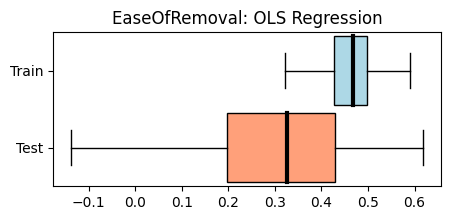

In [87]:
N = 1000
R2 = np.zeros((N,2))
coefs = np.zeros((N,X.shape[1]))

arr = np.arange(len(data))
testN = int(np.ceil(len(arr)*0.7))
    
for i in range(N):    
    rng = np.random.default_rng(i)
    choice = rng.choice(arr, testN, replace=False)
    nonchoice = np.setxor1d(arr, choice)

    X_train, y_train = X[choice].copy(), y[choice].copy()
    X_test, y_test = X[nonchoice].copy(), y[nonchoice].copy()

    ridge = lmodel.LinearRegression().fit(X_train, y_train)
    r2_train = ridge.score(X_train, y_train)

    y_pred = ridge.predict(X_test)
    r2_test = mets.r2_score(y_test, y_pred)
    R2[i] = [r2_train, r2_test]
    coefs[i] = ridge.coef_
    
fs = 12
reg = str(type(ridge)).split('.')[-1][:-2]

fig, ax = plt.subplots(1,1,figsize=(5,2))
colors = ['lightsalmon','lightblue']
bplot = ax.boxplot(np.flip(R2), notch=False, sym='', vert=False, widths=0.9, patch_artist=True,
                   medianprops={'lw':3, 'color':'k'}, labels=['Test', 'Train'])

for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        
ax.set_title(yvalue + ': OLS Regression', fontsize=fs);

filename = dst + yvalue.lower() + '_' + reg + '_R2_train_vs_test'
#plt.savefig(filename + '.jpg', dpi=150, bbox_inches='tight', pil_kwargs = {'optimize':True}, format='jpg')
#plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
print(filename)

In [89]:
pd.DataFrame(R2, columns=['Train', 'Test']).describe()

,Train,Test
count,1000.000000,1000.000000
mean,0.459855,0.293791
std,0.055229,0.189657
min,0.259852,-0.768506
25%,0.425998,0.197197
50%,0.468346,0.326856
75%,0.497235,0.429264
max,0.618238,0.618260


../hpcc/results/trad/easeofremoval_linearregression_coefs


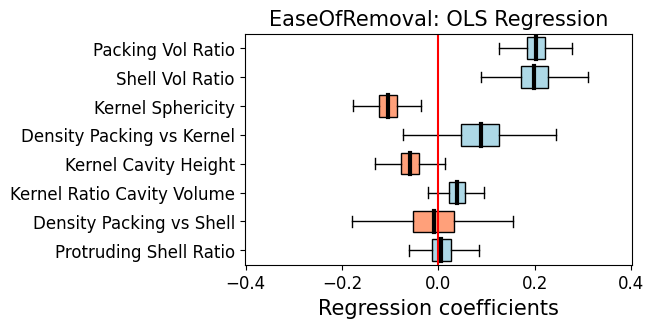

In [97]:
fs = 15
fabs = np.abs(np.mean(coefs, axis=0))
aabs = np.argsort(fabs)

fig, ax = plt.subplots(1,1,figsize=(5,3))

colors = ['lightsalmon','lightblue']

bplot = ax.boxplot(coefs[:,aabs], notch=False, sym='', vert=False, widths=0.75, patch_artist=True,
                   medianprops={'lw':3, 'color':'k'},
                   labels = labels.col_labels.iloc[r_vals].iloc[aabs])
ax.scatter([-np.max(coefs), np.max(coefs)], [5,5], c='w', alpha=0)

for i,patch in enumerate(bplot['boxes']):
    if mabs[i] > 0:
        patch.set_facecolor(colors[1])
    else:
        patch.set_facecolor(colors[0])

ax.axvline(0, c='r')
ax.set_title(yvalue + ': OLS Regression', fontsize=fs)
ax.set_xlabel('Regression coefficients', fontsize=fs)
ax.tick_params(labelsize=fs-3)

filename = dst + yvalue.lower() + '_' + reg.lower() + '_coefs'
#plt.savefig(filename + '.jpg', dpi=150, bbox_inches='tight', pil_kwargs = {'optimize':True}, format='jpg')
#plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
print(filename)

# Train/test, one last time

In [129]:
N = 100
arr = np.arange(len(data))
testN = int(np.ceil(len(arr)*0.7))
M = 3

dict22 = [{} for i in range(M)]

arr = np.arange(len(data))
testN = int(np.ceil(len(arr)*0.7))

choice = np.zeros((N,testN), dtype=int)
nonchoice = np.zeros((N, len(data) - testN), dtype=int)

for j in range(N):
    rng = np.random.default_rng(j)
    choice[j] = rng.choice(arr, testN, replace=False)
    nonchoice[j] = np.setxor1d(arr, choice[j])

for i in range(M):
    for comb in it.combinations(range(X.shape[1]), i+2):
        R2 = np.zeros((N,2))
        arrcomb = np.array(comb)
        X1 = X[:,arrcomb].copy()
        
        for j in range(N):
            X_train, y_train = X1[choice[j]].copy(), y[choice[j]].copy()
            X_test, y_test = X1[nonchoice[j]].copy(), y[nonchoice[j]].copy()

            ridge = lmodel.LinearRegression().fit(X_train, y_train)
            R2[j,0] = ridge.score(X_train, y_train)

            y_pred = ridge.predict(X_test)
            R2[j,1] = mets.r2_score(y_test, y_pred)
            
        dict22[i][comb] = R2

In [174]:
k = 1
describe = np.zeros((len(dict22[k]), 8, 2 ))
for i,key in enumerate(dict22[k]):
    describe[i] = pd.DataFrame(dict22[k][key]).describe().values

../hpcc/results/trad/easeofremoval_linearregression_7030


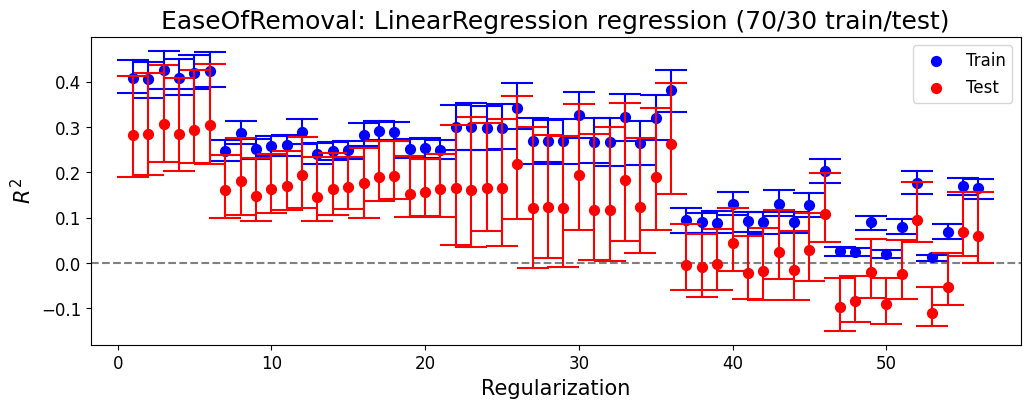

In [181]:
fs = 15
xaxis = np.arange(len(describe)) + 1
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax = np.atleast_1d(ax).ravel(); i=0

c = ['blue','red']
l = ['Train','Test']

for j in range(2):
    ax[i].scatter(xaxis, describe[:,1,j], color=c[j], label=l[j], s=50)
    ax[i].scatter(xaxis, describe[:,4,j], color=c[j], marker='_', s=500)
    ax[i].scatter(xaxis, describe[:,6,j], color=c[j], marker='_', s=500)
    for k in range(len(xaxis)):
        ax[i].plot([xaxis[k], xaxis[k]], describe[k,[4,6],j], color=c[j])

ax[i].axhline(0, c='gray', ls='--', zorder=-1)
ax[i].set_ylabel('$R^2$', fontsize=fs, rotation=90)
ax[i].set_xlabel('Regularization', fontsize=fs)
ax[i].tick_params(labelsize=fs-3)
ax[i].set_title(yvalue + ': ' + reg +' regression (70/30 train/test)', fontsize=fs+3)
ax[i].legend(fontsize=fs-3);

filename = dst + yvalue.lower() + '_' + reg.lower()+ '_7030'
#plt.savefig(filename + '.jpg', dpi=150, bbox_inches='tight', pil_kwargs = {'optimize':True}, format='jpg')
#plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
print(filename)

In [209]:
maxR2 = [{} for i in range(M)]
k = 2
for key in dict22[k]:
    maxR2[k][key] = np.mean(dict22[k][key], axis = 0)

maxval = 0
for key in dict22[k]:
    val = maxR2[k][key][0]
    if val > maxval:
        maxval = val
        maxarg = key
print(maxarg, maxval, maxR2[k][maxarg])

(0, 1, 4, 7) 0.4443853903779916 [0.44438539 0.3124418 ]


In [210]:
labels.col_labels.iloc[r_vals].iloc[np.array(maxarg)]

23              Shell Vol Ratio
24            Packing Vol Ratio
41            Kernel Sphericity
46    Density Packing vs Kernel
Name: col_labels, dtype: object

# Spectral Embedding

# Mutual information

../hpcc/results/trad/easeofremoval_mutual_info


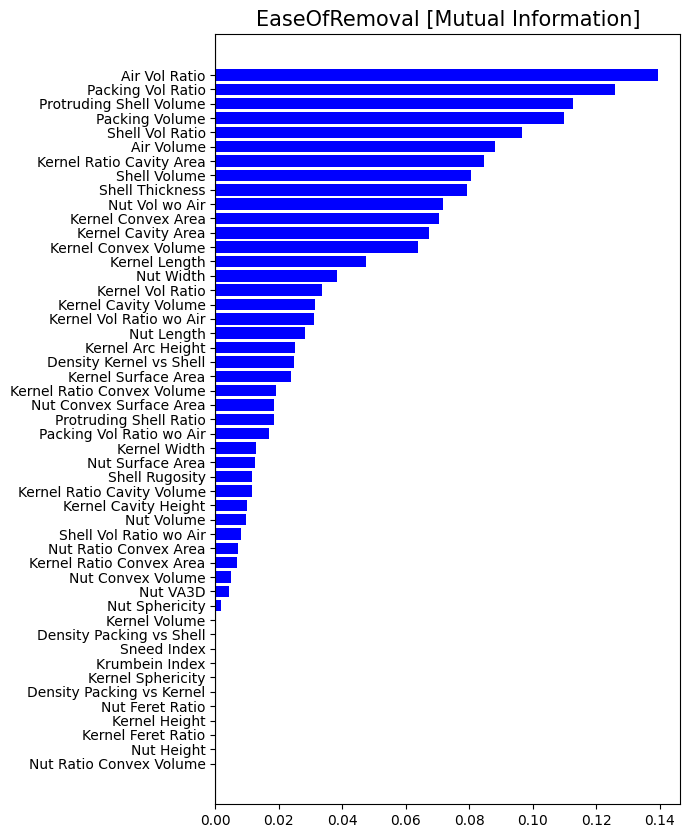

In [211]:
thr = 0.0

X = data.iloc[:,iniN:endN].values.copy()
y = data[yvalue].values.copy()

mi = fselection.mutual_info_regression(X,y,discrete_features=False,n_neighbors=6,random_state=42)
bmi = mi >= thr
ami = np.argsort(mi[bmi])

fig, ax = plt.subplots(1,1,figsize=(6,10))

ax.barh(np.arange(len(ami)), mi[bmi][ami], color='b',
        tick_label = labels.col_labels[iniN:endN].iloc[bmi].iloc[ami])
ax.set_title(yvalue + ' [Mutual Information]', fontsize=fs)
ax.axvline(0, c='k');

filename = dst + yvalue.lower() + '_mutual_info'
#plt.savefig(filename + '.jpg', dpi=150, bbox_inches='tight', pil_kwargs = {'optimize':True}, format='jpg')
#plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
print(filename)